In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:

# Reading the DataFrame back in to ensure it was saved correctly
loaded_df = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_Subtype_target_for_modeling.csv', index_col='CellID')
OS742_df = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS742/OS742_Subtype_target_for_modeling.csv', index_col='CellID')
OS833_df = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/OS833_Subtype_target_for_modeling.csv', index_col='CellID')

# Adjusting columns for consistency
OS833_df.columns.values[0] = 'State'
OS742_df.columns.values[0] = 'State'


# Combining DataFrames
combined_df = pd.concat([loaded_df, OS742_df, OS833_df])
combined_df['State'] = combined_df['State'].str.replace('Subtype', 'State', regex=False)


# Removing JUNB because absent in one cell line (NAs)
combined_df = combined_df.drop(columns=['JUNB'])

combined_df

,State,IRF1,JUN,NFE2L3,NFKB2,NR0B1,NT-ctrl,STAT1,TCF4,TSHZ2,cell_line
CellID,,,,,,,,,,,
AAACCCAAGCATTTCG-1,State B,0,0,0,0,0,0,0,0,1,OS384
AAAGGTAAGTGGCAGT-1,State B,0,0,1,0,0,0,0,0,0,OS384
AACCTTTAGACGAGCT-1,State A,0,0,1,0,0,0,0,0,0,OS384
AACCTTTAGTGTTGTC-1,State B,1,0,0,0,0,0,0,0,0,OS384
AACCTTTCAGATGCGA-1,State B,1,0,0,0,0,0,0,0,0,OS384
...,...,...,...,...,...,...,...,...,...,...,...
TTTACTGTCAGACAAA-1,State A,0,0,0,0,0,1,0,0,0,OS833
TTTGTTGAGAATTCAG-1,State C,0,0,0,0,0,1,0,0,0,OS833
TTTCACATCAAGTAAG-1,State B,1,0,0,0,0,0,0,0,0,OS833


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpr

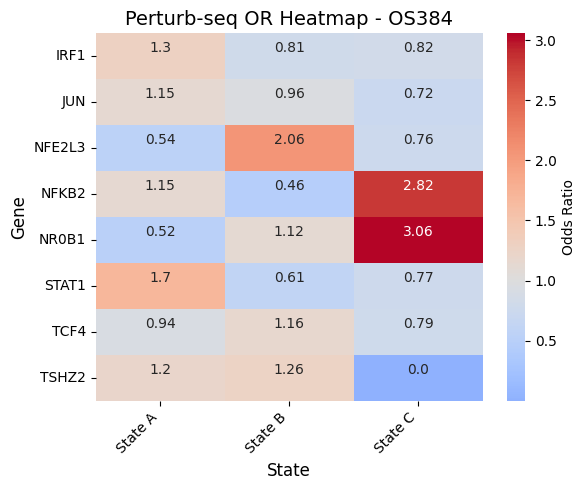

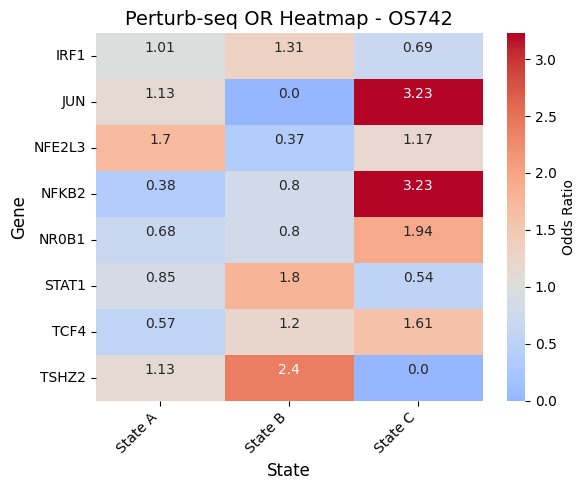

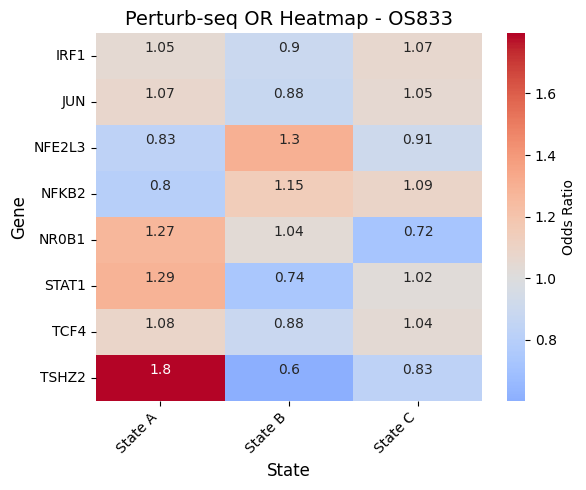

In [9]:
import os

df = combined_df.copy()

# Create a dictionary to store results for each cell line
results_by_cell_line = {}

# Identify unique cell lines in your DataFrame
cell_lines = df['cell_line'].unique()

for cl in cell_lines:
    
    # Subset the data to just this cell line
    sub_df = df[df['cell_line'] == cl].copy()

    # One-hot encode the State column
    state_dummies = pd.get_dummies(sub_df['State'])
    states = state_dummies.columns.tolist()

    # Define which perturbations/genes to test
    genes = ['IRF1', 'JUN', 'NFE2L3', 'NFKB2', 'NR0B1', 'STAT1', 'TCF4', 'TSHZ2']

    # Initialize a DataFrame to hold Odds Ratios (OR) and p-values
    idx = pd.Index(genes, name='Gene')
    cols = pd.MultiIndex.from_product([states, ['Odds Ratio', 'P-value']], 
                                      names=['State','Metric'])
    
    or_pvalues = pd.DataFrame(index=idx, columns=cols, dtype=float)

    for gene in genes:
        for state in states:
            # Response
            y = state_dummies[state]
            # Predictor
            X = sub_df[[gene]]
            X = sm.add_constant(X)

            try:
                model = sm.Logit(y, X)
                result = model.fit(disp=False)
                coef = result.params[gene]
                pval = result.pvalues[gene]
                or_pvalues.loc[gene, (state, 'Odds Ratio')] = np.exp(coef)
                or_pvalues.loc[gene, (state, 'P-value')] = pval
            except:
                or_pvalues.loc[gene, (state, 'Odds Ratio')] = np.nan
                or_pvalues.loc[gene, (state, 'P-value')] = np.nan

    # Multiple testing correction
    raw_pvals = or_pvalues.xs('P-value', level='Metric', axis=1).values.flatten()
    mask_nonnan = ~np.isnan(raw_pvals)
    pvals_nonnan = raw_pvals[mask_nonnan]

    rejected, corrected, _, _ = multipletests(pvals_nonnan, method='fdr_bh')
    corrected_full = raw_pvals.copy()
    corrected_full[mask_nonnan] = corrected
    corrected_matrix = corrected_full.reshape(or_pvalues.xs('P-value', level='Metric', axis=1).shape)
    or_pvalues.loc[:, (slice(None), 'P-value')] = corrected_matrix

    # Store
    results_by_cell_line[cl] = or_pvalues

def significance_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Loop over cell lines and plot
for cl, or_pvals in results_by_cell_line.items():
    odds_ratios = or_pvals.xs('Odds Ratio', level='Metric', axis=1)
    p_values = or_pvals.xs('P-value', level='Metric', axis=1)

    annotations = odds_ratios.round(2).astype(str) + '\n' + p_values.applymap(significance_star)
    mask = odds_ratios.isnull()

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        odds_ratios, 
        annot=annotations, 
        fmt='', 
        cmap='coolwarm', 
        center=1,        # Colormap is centered on 1
        cbar_kws={'label': 'Odds Ratio'},
        mask=mask
    )
    plt.title(f'Perturb-seq OR Heatmap - {cl}', fontsize=14)
    plt.xlabel('State', fontsize=12)
    plt.ylabel('Gene', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save as SVG on Desktop (adjust the file path to your username/location)
    outpath = f"/Users/brendamelano/Desktop/Perturb-seq_OR_Heatmap_{cl}.svg"
    plt.savefig(outpath, format='svg')

    plt.show()


In [11]:
odds_ratios

State,State A,State B,State C
Gene,,,
IRF1,1.045343,0.895414,1.066779
JUN,1.072558,0.881435,1.053816
NFE2L3,0.829222,1.304358,0.911795
NFKB2,0.800314,1.147059,1.087883
NR0B1,1.269754,1.037295,0.724649
STAT1,1.287429,0.736163,1.023075
TCF4,1.083096,0.883398,1.040593
TSHZ2,1.795278,0.602038,0.827687


In [13]:
or_pvalues

State     State A              State B              State C          
Metric Odds Ratio   P-value Odds Ratio   P-value Odds Ratio   P-value
Gene                                                                 
IRF1     1.045343  0.921883   0.895414  0.921883   1.066779  0.921883
JUN      1.072558  0.921883   0.881435  0.921883   1.053816  0.921883
NFE2L3   0.829222  0.858324   1.304358  0.858324   0.911795  0.921883
NFKB2    0.800314  0.858324   1.147059  0.921883   1.087883  0.921883
NR0B1    1.269754  0.858324   1.037295  0.921883   0.724649  0.858324
STAT1    1.287429  0.858324   0.736163  0.858324   1.023075  0.930251
TCF4     1.083096  0.921883   0.883398  0.921883   1.040593  0.921883
TSHZ2    1.795278  0.228438   0.602038  0.668425   0.827687  0.921883